<a href="https://colab.research.google.com/github/jlgelpi/enzyme_kinetics/blob/main/enzyme_kinetics_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def michaelis_menten_func(s, vm ,km):
  return vm * s / (km + s)

def competitive_inh_func(x, vm ,km, ki):
  s, i = x
  return vm * s / (km (1 + i/ki) + s)

def acompetitive_inh_func(x, vm ,km, ki):
  s, i = x
  return vm * s / (km + s * (1 + i/ki))

def lineweaver_burk_func(s, vm, km):
  return 1/vm + km/vm/s

def fit_inh_func(func, s, i, v):
  sdata = []
  idata = []
  for ival in i:
    for sval in s:
      sdata.append(sval)
      idata.append(ival)
  vdata = []
  for gr in v:
    for vval in gr:
      vdata.append(vval)
  sdata = np.array(sdata)
  idata = np.array(idata)
  vdata = np.array(vdata)
  print(sdata)
  print(idata)
  print(vdata)
  return curve_fit(func, np.stack([sdata, idata]), vdata)

In [29]:
s = np.array([0.2, 0.4, 0.8, 1.6, 3.2])
i = np.array([0.0, 1.5, 1.5])
vo = np.array([1.67, 2.86, 4.44, 6.15, 7.62])
via = np.array([0.625, 1.176, 2.110, 3.480, 5.16])
vib = np.array([0.83, 1.43, 2.22, 3.08, 3.81])

In [30]:
[vm, km], pcovo = curve_fit(michaelis_menten_func, s, vo)
[vma, kma], pcova = curve_fit(michaelis_menten_func, s, via)
[vmb, kmb], pcovb = curve_fit(michaelis_menten_func, s, vib)

In [31]:
vm, km

(9.99761261755516, 0.999836186424034)

In [32]:
vma, kma

(9.976308094138021, 2.9866329445904154)

In [33]:
vmb, kmb


(5.0046414747207555, 1.0020019641941045)

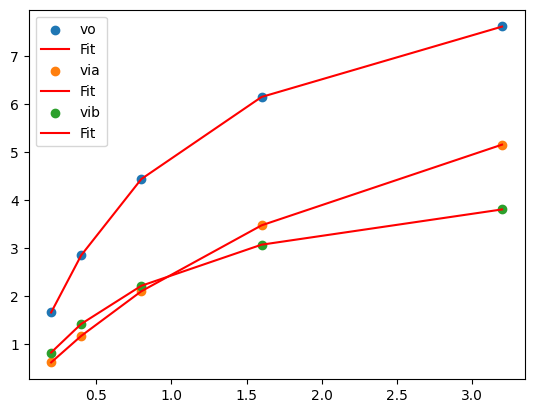

In [34]:
plt.scatter(s, vo, label="vo")
plt.plot(s, michaelis_menten_func(s, vm, km), "r-", label="Fit")
plt.scatter(s, via, label="via")
plt.plot(s, michaelis_menten_func(s, vma, kma), "r-", label="Fit")
plt.scatter(s, vib, label="vib")
plt.plot(s, michaelis_menten_func(s, vmb, kmb), "r-", label="Fit")
plt.legend()
plt.show()

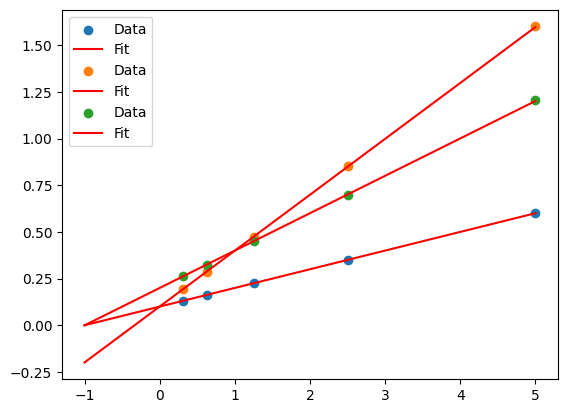

In [35]:
s0 = np.append(s, -km)
plt.scatter(1/s, 1/vo, label="Data")
plt.plot(1/s0, lineweaver_burk_func(s0, vm, km), "r-", label="Fit")
plt.scatter(1/s, 1/via, label="Data")
plt.plot(1/s0, lineweaver_burk_func(s0, vma, kma), "r-", label="Fit")
plt.scatter(1/s, 1/vib, label="Data")
plt.plot(1/s0, lineweaver_burk_func(s0, vmb, kmb), "r-", label="Fit", )
plt.legend()
plt.show()

In [36]:
s = np.array([0.02, 0.05, 0.1, 0.2, 0.5])
i = np.array([0.,0.1, 1.])
v = np.array([
    [2.9, 5., 6.67, 8.13, 9.09],
    [2.52, 4.02, 5.02, 5.72, 6.25],
    [1.18, 1.43, 1.54, 1.6, 1.64]
])



In [67]:

prm, cov = fit_inh_func(acompetitive_inh_func, s, i, v)
print(prm,cov)

[0.02 0.05 0.1  0.2  0.5  0.02 0.05 0.1  0.2  0.5  0.02 0.05 0.1  0.2
 0.5 ]
[0.  0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.1 1.  1.  1.  1.  1. ]
[2.9  5.   6.67 8.13 9.09 2.52 4.02 5.02 5.72 6.25 1.18 1.43 1.54 1.6
 1.64]
[10.03616927  0.04969082  0.19842779] [[ 1.23332451e-03  1.59931410e-05 -3.87416376e-05]
 [ 1.59931410e-05  3.18137210e-07 -3.24171313e-07]
 [-3.87416376e-05 -3.24171313e-07  4.24634803e-06]]


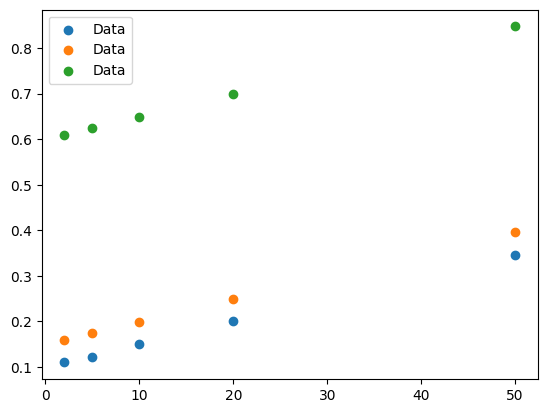

In [37]:
plt.scatter(1/s, 1/v[0], label="Data")
plt.scatter(1/s, 1/v[1], label="Data")
plt.scatter(1/s, 1/v[2], label="Data")
plt.legend()
plt.show()

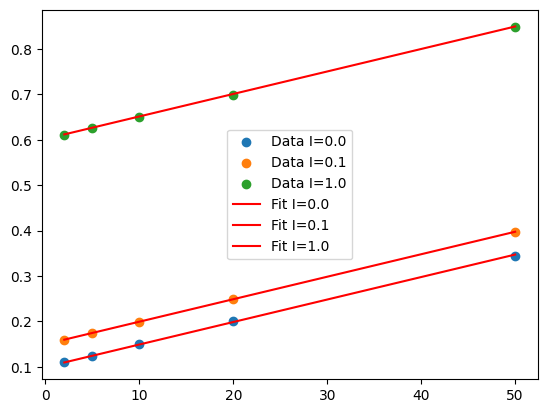

In [69]:
plt.scatter(1/s, 1/v[0], label=f"Data I=0.0")
plt.scatter(1/s, 1/v[1], label=f"Data I=0.1")
plt.scatter(1/s, 1/v[2], label=f"Data I=1.0")
for ival in i:
  vmap = prm[0] / (1 + ival/prm[2])
  kmap = prm[1] / (1 + ival/prm[2])
  plt.plot(1/s, lineweaver_burk_func(s, vmap , kmap), "r-", label=f"Fit I={ival}")
plt.legend()
plt.show()